<a href="https://colab.research.google.com/github/robot-or-brain/robot_or_brain/blob/main/robot_or_brain_POC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 11.9 MB/s 
     |████████████████████████████████| 145 kB 74.9 MB/s 
     |████████████████████████████████| 181 kB 65.2 MB/s 
     |████████████████████████████████| 63 kB 1.4 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=355dcfba1347a0e2e65edf23aa7307e681e4ffe44e7b179c7b4b69b602f739b9
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built pathtools


In [3]:
!wandb login

wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [4]:
import wandb
from wandb.keras import WandbCallback

wandb.init(project="robot-or-brain-POC", entity="robot-or-brain")


wandb: Currently logged in as: maartenvm (robot-or-brain). Use `wandb login --relogin` to force relogin


In [62]:
config = {
  "learning_rate": 0.001,
  "epochs": 100,
  "batch_size": 128
}

wandb.config = config

In [64]:
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet_v2 import preprocess_input, decode_predictions
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
import numpy as np

We choose to do pooling to reduce the feature vectors to the amount of output classes. We might need to change this in the future if we want to display what part of the images contributed most to the classification.

In [55]:
base_model = ResNet50V2(
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    input_shape=None,
    pooling='avg'
)

In [56]:
features = base_model.output
fully_connected_output = Dense(1024, activation='relu')(features)
predictions = Dense(8, activation='softmax')(fully_connected_output)

In [57]:
# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

In [58]:
# Training only top layers i.e. the layers which we have added in the end
for layer in base_model.layers:
    layer.trainable = False

In [67]:
# Compiling the model
model.compile(optimizer=Adam(lr=config['learning_rate']), loss='categorical_crossentropy', metrics = ['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [51]:
!wget "https://mtintegraal.nl/media/articles/926/ai-technische-onmogelijkheden.jpg"

--2022-05-25 13:01:11--  https://mtintegraal.nl/media/articles/926/ai-technische-onmogelijkheden.jpg
Resolving mtintegraal.nl (mtintegraal.nl)... 185.85.17.53
Connecting to mtintegraal.nl (mtintegraal.nl)|185.85.17.53|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 189355 (185K) [image/jpeg]
Saving to: ‘ai-technische-onmogelijkheden.jpg.1’

ai-technische-onmog 100%[===================>] 184.92K  --.-KB/s    in 0.02s   

2022-05-25 13:01:11 (11.8 MB/s) - ‘ai-technische-onmogelijkheden.jpg.1’ saved [189355/189355]



(1, 224, 224, 3)


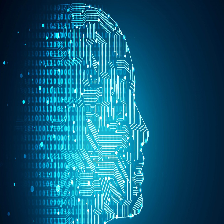

In [52]:

img_path = 'ai-technische-onmogelijkheden.jpg'
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

print(x.shape)
img


In [53]:
preds = model.predict(x)
preds.shape

(1, 8)

We might want to augment our data with variations to make the network more robust to image scale and other transformations

In [ ]:
# Creating objects for image augmentations
# train_datagen = ImageDataGenerator(rescale = 1./255,
#                                    shear_range = 0.2,
#                                    zoom_range = 0.2,
#                                    horizontal_flip = True)
 
# test_datagen = ImageDataGenerator(rescale = 1./255)



In [ ]:
model.fit(X_train, y_train, validation_data=(X_test, y_test), callbacks=[WandbCallback()])